<a href="https://colab.research.google.com/github/al3jandroR/nba_predictions/blob/injury_report/nba_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nba_api

In [ ]:
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.static import teams
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from nba_api.stats.endpoints import scoreboardv2
from datetime import datetime, timedelta
from pytz import timezone
import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
nba_teams = teams.get_teams()
teams_df = pd.DataFrame(nba_teams)

In [ ]:
# Helper function to avoid api rate limits
def safe_request(func, *args, **kwargs):
    while True:
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"Error: {e}. Retrying in 5 seconds...")
            time.sleep(5)

def get_team_id(abbr):
    team = teams_df[teams_df['abbreviation'] == abbr.upper()]
    if not team.empty:
        return team.iloc[0]['id']
    else:
        raise ValueError(f"Team abbreviation '{abbr}' not found.")

def get_team_abbr(team_id):
    team = teams_df[teams_df['id'] == team_id]
    if not team.empty:
        return team.iloc[0]['abbreviation']
    else:
        raise ValueError(f"No team found for ID: {team_id}")

def get_team_name(team_id):
    team = teams_df[teams_df['id'] == team_id]
    if not team.empty:
        return team.iloc[0]['full_name']
    else:
        raise ValueError(f"No team found for ID: {team_id}")

def get_team_stats(team_id, season, n=5):
    log = safe_request(teamgamelog.TeamGameLog, team_id=team_id, season=season)
    df = log.get_data_frames()[0]

    df = df[['GAME_DATE', 'MATCHUP', 'WL', 'PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']].copy()

    df['SEASON'] = season
    df['TEAM'] = get_team_name(team_id)
    df['HOME'] = df['MATCHUP'].str.contains('vs.').astype(int)
    df['WIN'] = df['WL'].apply(lambda x: 1 if x == 'W' else 0)
    df['STREAK'] = df['WIN'].rolling(window=n).sum().shift(-1).fillna(0)
    df['OPP_ABBR'] = df['MATCHUP'].str.extract(r'@ (\w+)|vs\. (\w+)').bfill(axis=1).iloc[:, 0]

    # avg stats from last 5 games
    rolling_features = ['PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']
    for col in rolling_features:
        df[f'{col}_AVG'] = df[col].rolling(window=n).mean().shift(-1)

    df['DEFENSE_SCORE'] = df['STL_AVG'] + df['BLK_AVG'] + df['DREB_AVG']
    df['AST_TOV_RATIO'] = df['AST_AVG'] / (df['TOV_AVG'] + 1)
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], format='%b %d, %Y')
    df['EFFICIENCY'] = df['FG_PCT_AVG'] * df['PTS_AVG']
    df['PREV_GAME_DATE'] = df['GAME_DATE'].shift(-1)
    df['DAYS_REST'] = (df['GAME_DATE'] - df['PREV_GAME_DATE']).dt.days.clip(lower=0)
    df['BACK_TO_BACK'] = (df['GAME_DATE'] - df['PREV_GAME_DATE']).dt.days.eq(1).astype(int)
    df['B2B_ROAD'] = (df['BACK_TO_BACK'] == 1) & (df['HOME'] == 0).astype(int)

    df['FORM_SCORE'] = df['AST_TOV_RATIO'] + df['DEFENSE_SCORE'] + df['EFFICIENCY']

    df = df.dropna().reset_index(drop=True)
    return df

def add_opponent_features(df):
    abbr_to_name = teams_df.set_index('abbreviation')['full_name'].to_dict()
    df['OPPONENT_TEAM'] = df['OPP_ABBR'].map(abbr_to_name)

    df['GAME_KEY'] = df['GAME_DATE'].astype(str) + "_" + df['TEAM']
    df['OPP_GAME_KEY'] = df['GAME_DATE'].astype(str) + "_" + df['OPPONENT_TEAM']

    eff_map = df.set_index('GAME_KEY')['EFFICIENCY'].to_dict()
    form_map = df.set_index('GAME_KEY')['FORM_SCORE'].to_dict()
    streak_map = df.set_index('GAME_KEY')['STREAK'].to_dict()

    df['OPP_EFFICIENCY'] = df['OPP_GAME_KEY'].map(eff_map).fillna(0)
    df['OPP_FORM_SCORE'] = df['OPP_GAME_KEY'].map(form_map).fillna(0)
    df['OPP_STREAK'] = df['OPP_GAME_KEY'].map(streak_map).fillna(0)

    df['NET_EFFICIENCY'] = df['EFFICIENCY'] - df['OPP_EFFICIENCY']
    df['NET_FORM_SCORE'] = df['FORM_SCORE'] - df['OPP_FORM_SCORE']
    df['NET_STREAK'] = df['STREAK'] - df['OPP_STREAK']

    df = df.dropna().reset_index(drop=True)
    return df

In [ ]:
all_team_dfs = []
seasons = ['2023-24', '2024-25']
for season in seasons:
  for team in nba_teams:
      try:
          print(f"Loading {team['full_name']} - {season}...")
          team_data = get_team_stats(team['id'], season)
          team_data['Team'] = team['full_name']

          all_team_dfs.append(team_data)
          time.sleep(1.5)
      except Exception as e:
          print(f"Skipping {team['full_name']} due to error")

Loading Atlanta Hawks - 2023-24...
Loading Boston Celtics - 2023-24...
Loading Cleveland Cavaliers - 2023-24...
Loading New Orleans Pelicans - 2023-24...
Loading Chicago Bulls - 2023-24...
Loading Dallas Mavericks - 2023-24...
Loading Denver Nuggets - 2023-24...
Loading Golden State Warriors - 2023-24...
Loading Houston Rockets - 2023-24...
Loading Los Angeles Clippers - 2023-24...
Loading Los Angeles Lakers - 2023-24...
Loading Miami Heat - 2023-24...
Loading Milwaukee Bucks - 2023-24...
Loading Minnesota Timberwolves - 2023-24...
Loading Brooklyn Nets - 2023-24...
Loading New York Knicks - 2023-24...
Loading Orlando Magic - 2023-24...
Loading Indiana Pacers - 2023-24...
Loading Philadelphia 76ers - 2023-24...
Loading Phoenix Suns - 2023-24...
Loading Portland Trail Blazers - 2023-24...
Loading Sacramento Kings - 2023-24...
Loading San Antonio Spurs - 2023-24...
Loading Oklahoma City Thunder - 2023-24...
Loading Toronto Raptors - 2023-24...
Loading Utah Jazz - 2023-24...
Loading Memph

In [ ]:
df = pd.concat(all_team_dfs).reset_index(drop=True)
team_data = add_opponent_features(df)
features = ['AST_TOV_RATIO', 'DEFENSE_SCORE', 'EFFICIENCY', 'FG_PCT_AVG', 'PTS_AVG', 'HOME', 'B2B_ROAD', 'DAYS_REST', 'BACK_TO_BACK', 'FORM_SCORE', 'NET_FORM_SCORE', 'NET_EFFICIENCY', 'NET_STREAK', 'STREAK']
X = df[features]
y = df['WIN']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
best_model = None
best_score = 0
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

rf_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=sss, scoring='accuracy')
rf_grid.fit(X_train, y_train)
print("Best Random Forest params:", rf_grid.best_params_)
print("Best Random Forest score:", rf_grid.best_score_)
if rf_grid.best_score_ > best_score:
    best_score = rf_grid.best_score_
    best_model = rf_grid.best_estimator_

gb_param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=sss, scoring='accuracy')
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting params:", gb_grid.best_params_)
print("Best Gradient Boosting score:", gb_grid.best_score_)
if gb_grid.best_score_ > best_score:
    best_score = gb_grid.best_score_
    best_model = gb_grid.best_estimator_

Best Random Forest params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest score: 0.7736514522821576
Best Gradient Boosting params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting score: 0.7755186721991701


Model Accuracy: 0.80
Train Accuracy: 0.80
Test Accuracy:  0.80


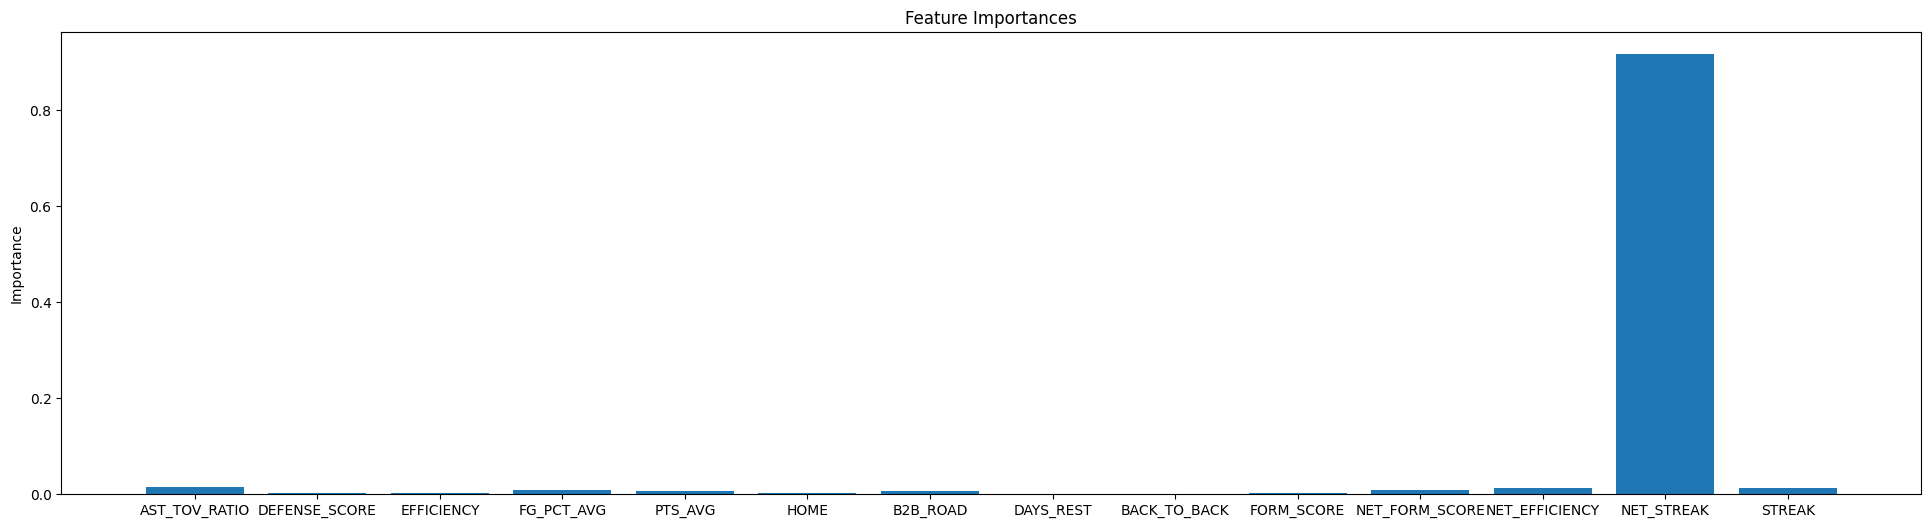

Feature Comparison (F-test vs Model Importance):
Feature                 F-Score     Model Importance
AST_TOV_RATIO            137.05               0.0159
DEFENSE_SCORE            192.82               0.0026
EFFICIENCY               292.67               0.0024
FG_PCT_AVG               229.97               0.0084
PTS_AVG                  275.64               0.0058
HOME                      18.17               0.0036
B2B_ROAD                  13.40               0.0069
DAYS_REST                  2.93               0.0009
BACK_TO_BACK               8.78               0.0001
FORM_SCORE               411.17               0.0036
NET_FORM_SCORE           819.40               0.0081
NET_EFFICIENCY           648.21               0.0125
NET_STREAK              2327.20               0.9165
STREAK                  1156.01               0.0127


In [ ]:
clf = best_model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy:  {test_acc:.2f}")

importances = clf.feature_importances_
plt.figure(figsize=(24, 6))
plt.bar(features, importances)
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.show()

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)
f_scores = selector.scores_

print("Feature Comparison (F-test vs Model Importance):")
print("{:<20s} {:>10s} {:>20s}".format("Feature", "F-Score", "Model Importance"))
for name, f, imp in zip(X_train.columns, f_scores, importances):
    print(f"{name:<20s} {f:10.2f} {imp:20.4f}")

Win rates by BACK_TO_BACK status:
BACK_TO_BACK
0    0.513499
1    0.437884
Name: WIN, dtype: float64


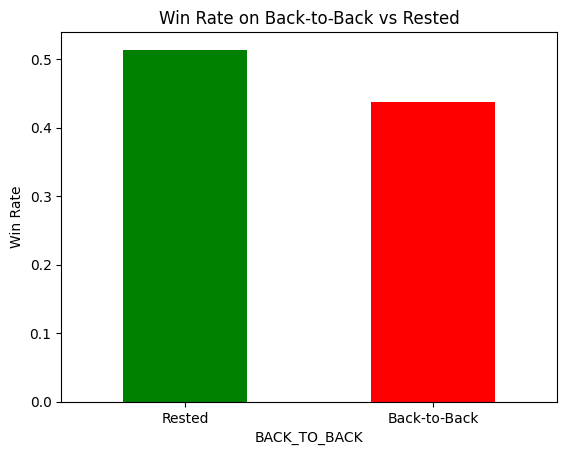

In [ ]:
b2b_grouped = df.groupby('BACK_TO_BACK')['WIN'].mean()
print("Win rates by BACK_TO_BACK status:")
print(b2b_grouped)

b2b_grouped.plot(kind='bar', color=['green', 'red'], title='Win Rate on Back-to-Back vs Rested')
plt.xticks([0, 1], ['Rested', 'Back-to-Back'], rotation=0)
plt.ylabel('Win Rate')
plt.show()

b2b_penalty_ratio = b2b_grouped[1] / b2b_grouped[0]

In [ ]:
url = 'https://www.espn.com/nba/injuries'
dfs = pd.read_html(url)
player_to_team = {}
for df in dfs:
    df = df[['NAME', 'STATUS', 'EST. RETURN DATE']].copy()
    print(df)

              NAME      STATUS EST. RETURN DATE
0       Trae Young  Day-To-Day           Apr 10
1     Jacob Toppin         Out           Apr 10
2  Larry Nance Jr.         Out            May 1
3     Clint Capela         Out           Apr 15
4    Jalen Johnson         Out            Oct 1
5      Kobe Bufkin         Out            Oct 1
                 NAME STATUS EST. RETURN DATE
0        Jaylen Brown    Out           Apr 11
1          Al Horford    Out           Apr 11
2  Kristaps Porzingis    Out           Apr 11
3        Jrue Holiday    Out           Apr 11
4       Derrick White    Out           Apr 11
5        Jayson Tatum    Out           Apr 11
               NAME STATUS EST. RETURN DATE
0    Day'Ron Sharpe    Out           Apr 11
1   Cameron Johnson    Out           Apr 11
2  D'Angelo Russell    Out           Apr 11
3      Noah Clowney    Out            Oct 1
4        Cam Thomas    Out            Oct 1
          NAME      STATUS EST. RETURN DATE
0    Tre Jones         Out        

In [ ]:
from nba_api.stats.endpoints import CommonTeamRoster
def get_all_rosters():
    all_rosters = []

    for _, row in teams_df.iterrows():
        team_id = row['id']
        team_abbr = row['abbreviation']
        team_name = row['full_name']

        try:
            roster = CommonTeamRoster(team_id=team_id, season='2024-25')
            roster_df = roster.get_data_frames()[0]  # Player info
            roster_df['TEAM'] = team_abbr
            all_rosters.append(roster_df)
            time.sleep(1)  # To avoid API timeout
        except Exception as e:
            print(f"Skipping {team_name} due to error: {e}")

    final_roster = pd.concat(all_rosters, ignore_index=True)
    final_roster.columns = final_roster.columns.str.upper()
    return final_roster[['PLAYER', 'TEAM']]

In [ ]:
def get_injuries():
    url = "https://www.espn.com/nba/injuries"
    tables = pd.read_html(url)

    all_injuries = []

    for table in tables:
        all_injuries.append(table)

    if not all_injuries:
        print("No injuries posted today.")
        return pd.DataFrame()

    df = pd.concat(all_injuries, ignore_index=True)
    df.columns = df.columns.str.upper()
    return df[['NAME', 'STATUS', 'EST. RETURN DATE']]

In [ ]:
injury_df = get_injuries()
roster_df = get_all_rosters()

injury_df = injury_df.merge(
    roster_df[['PLAYER', 'TEAM']],
    left_on='NAME',
    right_on='PLAYER',
    how='left'
)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 0)
pd.set_option('display.colheader_justify', 'left')

In [ ]:
print(injury_df)

    NAME                      STATUS      EST. RETURN DATE PLAYER                    TEAM
0                  Trae Young  Day-To-Day  Apr 10                         Trae Young  ATL
1                Jacob Toppin         Out  Apr 10                       Jacob Toppin  ATL
2             Larry Nance Jr.         Out   May 1                    Larry Nance Jr.  ATL
3                Clint Capela         Out  Apr 15                       Clint Capela  ATL
4               Jalen Johnson         Out   Oct 1                      Jalen Johnson  ATL
5                 Kobe Bufkin         Out   Oct 1                        Kobe Bufkin  ATL
6                Jaylen Brown         Out  Apr 11                       Jaylen Brown  BOS
7                  Al Horford         Out  Apr 11                         Al Horford  BOS
8          Kristaps Porzingis         Out  Apr 11                                NaN  NaN
9                Jrue Holiday         Out  Apr 11                       Jrue Holiday  BOS
10        

In [ ]:
def get_team_injuries(team_abbr, injury_df):
    team_injuries = injury_df[injury_df['TEAM'] == team_abbr]

    if team_injuries.empty:
        return "None"

    # Return a string of player names with their status
    return ", ".join(f"{row['NAME']} ({row['STATUS']})" for _, row in team_injuries.iterrows())

In [ ]:
#####--------RUN MODEL FOR TODAYS GAMES--------#####
today = datetime.now(timezone('US/Eastern')).strftime('%Y-%m-%d')
tomorrow = (datetime.now(timezone('US/Eastern')) + timedelta(days=1)).strftime('%Y-%m-%d')
date = today

print("Fetching games for:", date, "\n")
scoreboard = safe_request(scoreboardv2.ScoreboardV2, game_date=date)
games = scoreboard.get_data_frames()[0]

matchups = games[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

output = []

for _, row in matchups.iterrows():
    home_id = row['HOME_TEAM_ID']
    away_id = row['VISITOR_TEAM_ID']
    home = get_team_abbr(home_id)
    away = get_team_abbr(away_id)

    try:
        home_df = get_team_stats(home_id, season='2024-25').head(1).copy()
        away_df = get_team_stats(away_id, season='2024-25').head(1).copy()

        home_df['OPP_ABBR'] = away
        away_df['OPP_ABBR'] = home

        matchup_df = pd.concat([home_df, away_df], ignore_index=True)
        matchup_df = add_opponent_features(matchup_df)

        home_stats = matchup_df[matchup_df['TEAM'] == get_team_name(home_id)].copy()
        away_stats = matchup_df[matchup_df['TEAM'] == get_team_name(away_id)].copy()

        X_home = home_stats[features]
        X_away = away_stats[features]

        home_proba = clf.predict_proba(X_home)[0][1]
        away_proba = clf.predict_proba(X_away)[0][1]
        total = home_proba + away_proba
        nhome_proba = home_proba / total
        naway_proba = away_proba / total

        winner = home if home_proba > away_proba else away

        home_injuries = get_team_injuries(home, injury_df)
        away_injuries = get_team_injuries(away, injury_df)

        output.append({
            'Date': date,
            'Matchup': f"{away} @ {home}",
            'Predicted_Winner': winner,
            'Home_Prob': round(nhome_proba, 2),
            'Home_raw': round(home_proba, 2),
            'Away_Prob': round(naway_proba, 2),
            'Away_raw': round(away_proba, 2),
            'Home_Injuries': home_injuries,
            'Away_Injuries': away_injuries
        })

    except Exception as e:
        print(f"Error predicting {away} @ {home}: {e}")

output_df = pd.DataFrame(output)
pd.set_option('display.max_columns', None)
print(print(output_df.to_string(index=False)))

Fetching games for: 2025-04-09 

Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
Date   